# Pat's startup

# Product and market


Our product is a straightforward, AI-driven tool for optimizing pricing in Series A/B SaaS companies. It quickly determines the most profitable prices, addressing key challenges faced by CEOs in this sector.

**Core Functionality**
Uses AI and econometrics to set optimal prices.
Delivers results in minutes, not months.

**Problem's Solved:**
Tackles the opportunity cost of ineffective pricing.
Eliminates the need for expensive consultants.
Reduces the risk of revenue loss or growth slowdown due to poor pricing.

**User Experience:**
Designed for ease of use, making complex pricing strategies accessible.
Addresses concerns about data privacy and method trustworthiness.

**Risk Management:**
Offers a money-back guarantee if it doesn't lead to immediate revenue uplift.
Demonstrated effectiveness through case studies from companies X, Y, and Z.

This tool empowers CEOs to make informed, data-backed pricing decisions efficiently, ensuring competitiveness in a fast-paced market.

# Discrete choice and random utility models

Discrete choice models the probability of a consumer choosing $j$ MECE choices as a function of some attribute. A natural attribute is price.
In the context product choice, this usually means an $N+1$-dimesional demand system with $N$ inside goods and 1 additional 'Other' or 'No purchase' option.

In the eyes of the decision maker, each choice $j$ is associated with a utility $U_j$. The decision maker will choose the alternative with the highest $U$.

However, $U$ is not entirely determinstic. Total utility $U$ can be decomposed into a determinsitic component $V_j$ (observable to researcher), and an unobserved random variable $\epsilon_j$ which is Gumbel distributed.



# Import

### Import data

Firstly, we bring in our data. We require the user to upload transaction data of all their historical paid conversions. In general, more data is better.

We need five variables:

- An anonymised, unique identifier for the customer
- The name of the product that was purchased
- The price of the product that was purchased
- The number of units of the product purchased
- The revenue of the purchase

If privacy is an issue, we encourage customers to 

In [3]:
def import_data():
    import pandas as pd
    file_path = '/Users/patricksweeney/growth/07_Apps/Untitled Folder/Disaggregate models/Choice data 2.xlsx'
    data = pd.read_excel(file_path)
    return data

data = import_data()
data.head()

,id,product,revenue,volume,price
0,d4a531d7-c73b-4d28-badf-e38d99d637f9,Starter,18.0,1,18.0
1,7b1ebf39-f6c6-4b8e-ba80-715b2a346413,Team,90.0,3,30.0
2,e350df96-c3f4-4768-be1e-86c4fd32f39d,Team,105.0,3,35.0
3,b4d3bcc4-4045-49b8-9639-d3082fd03cf1,Starter,18.0,2,9.0
4,1249c200-3688-4c28-8a77-57974d303578,Team,180.0,6,30.0


### Other inputs

Apart from this data, we need a few additional pieces of info, and it's important we collect it in a user-friendly way:
- Total revenue, customers, and users as of today (in case the sample is partial, need it for lift)
- 'Order' of packages (i.e. which one is lowest priced, which one is highest price) — actually, probably can figure this out ourself
- If they're deleting a package, which one are they deleting.
- Which packages are self-serve, which ones are Enterprise.

### Check the data

We check the data to make sure nothing strange is going on. We want to confirm that:
- All IDs are unique
- $R = P \times V$
- $R > 0$
- $P > 0$
- $V > 0$

In [56]:
def check_data(data):
    # Check for unique IDs
    total_rows = len(data)
    duplicate_ids = total_rows - data['id'].nunique()
    if duplicate_ids > 0:
        duplicate_percentage = (duplicate_ids / total_rows) * 100
        print(f"Warning: {duplicate_percentage:.2f}% of the rows have duplicate IDs.")
    else:
        print("All IDs are unique.")

    # Compare total sum of revenue to sumproduct of price and volume
    total_revenue = data['revenue'].sum()
    total_price_volume = (data['price'] * data['volume']).sum()
    if total_revenue != total_price_volume:
        difference = total_price_volume - total_revenue
        percentage_difference = (difference / total_revenue) * 100
        print(f"Warning: Total P x V is {percentage_difference:.2f}% {'greater' if difference > 0 else 'less'} than total Revenue.")
    else:
        print("Total Revenue equals total Price times Volume.")

    # Check if revenue, price, volume are greater than 0 and calculate percentages
    for column in ['revenue', 'price', 'volume']:
        incorrect_values = data[data[column] <= 0]
        if not incorrect_values.empty:
            incorrect_percentage = (len(incorrect_values) / total_rows) * 100
            print(f"Warning: {incorrect_percentage:.2f}% of {column} values are not greater than 0.")
        else:
            print(f"All {column} values are greater than 0.")

# Example usage
check_data(data)


All IDs are unique.
Total Revenue equals total Price times Volume.
All revenue values are greater than 0.
All price values are greater than 0.
All volume values are greater than 0.


# Summary statistics

### Business-level summary

The business level summary gives the user a bird's eye view of their business. None of this information should be new to them, but it helps them have faith we've gotten the data properly.

We want to show them a page which confirms the size and main statistics of the sample:

- Total revenue
- Total customers
- Total users
- ARPA
- ARPU

It's probably a good idea for them to enter their total revenue, so we can print all of this out as a percentage. This will also let us calculate lift down the line.  Or maybe we just ask them for everything?

In [41]:
def revenue_summary(data):
    import pandas as pd

    # Calculate total revenue
    total_revenue = data['revenue'].sum()
    print(f"Total revenue: ${total_revenue:,.2f}")
    print()

    # Calculate total number of distinct customers
    total_customers = data['id'].nunique()
    print(f"Total customers: {total_customers}")

    # Calculate Average Revenue Per Account (ARPA)
    if total_customers > 0:
        arpa = total_revenue / total_customers
        print(f"Average revenue per customer: ${arpa:,.2f}")
    else:
        print("Average revenue per customer: N/A")
    print()

    # Calculate total volume
    total_volume = data['volume'].sum()
    print(f"Total users: {total_volume}")

    # Calculate Average Revenue Per User Account (ARPUA)
    if total_volume > 0:
        arpua = total_revenue / total_volume
        print(f"Average revenue per user: ${arpua:,.2f}")
    else:
        print("Average revenue per user: N/A")
    print()


revenue_summary(data)


Total revenue: $776,904.33

Total customers: 2974
Average revenue per customer: $261.23

Total users: 15186
Average revenue per user: $51.16



### Product-level summary

Next, we want to go one level deeper and summarise each product with plots. For each product, we're after:

- Revenue mix
- Customer mix
- User mix
- ARPA
- ARPU

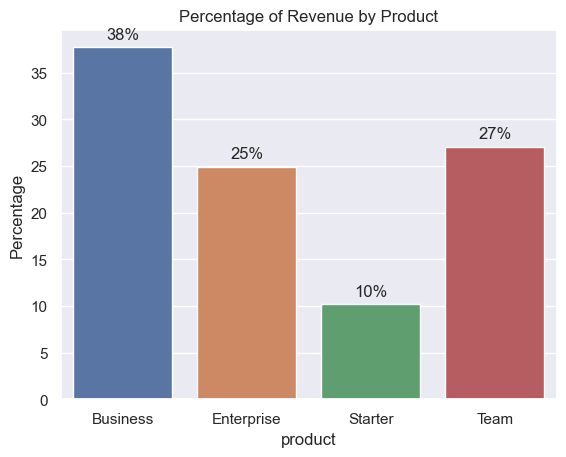

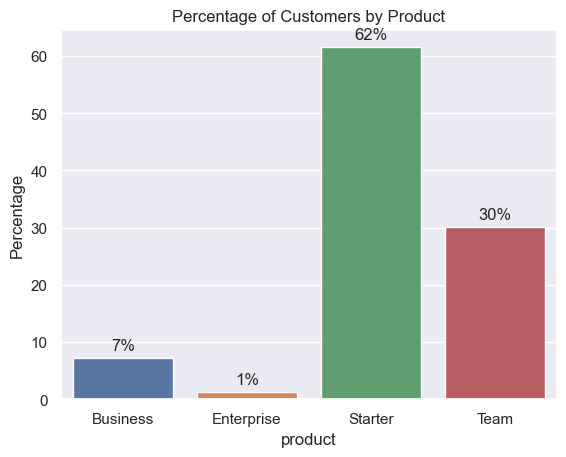

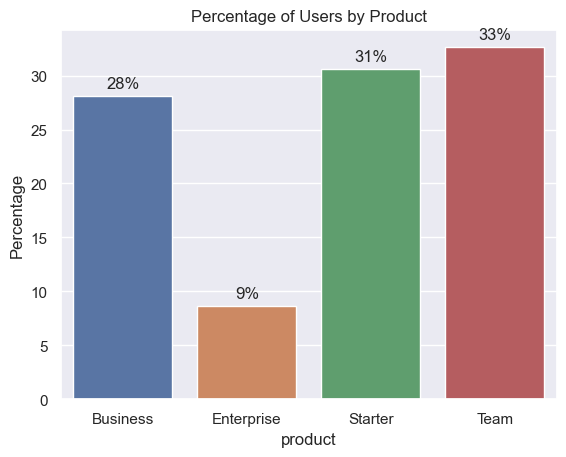

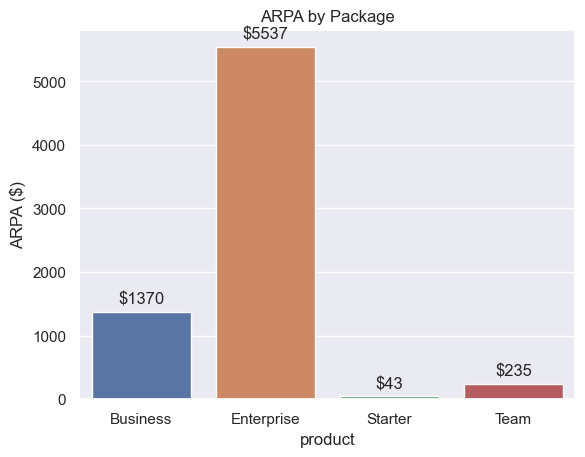

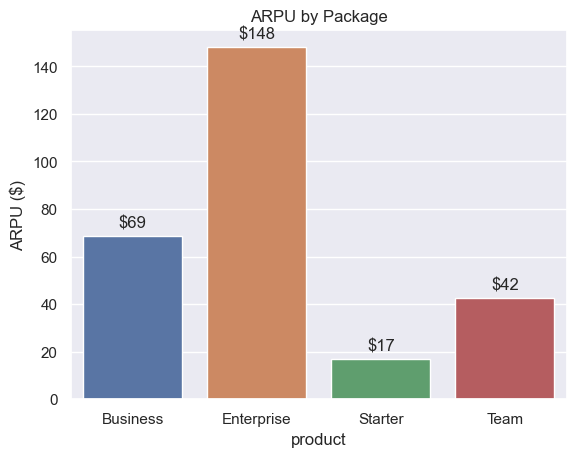

In [43]:
def package_summary(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Set Seaborn dark theme
    sns.set_theme(style="darkgrid")

    # Helper function to plot bar chart
    def plot_bar_chart(series, title, ylabel, value_format):
        ax = sns.barplot(x=series.index, y=series.values)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        for p in ax.patches:
            ax.annotate(value_format.format(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
        plt.show()

    # Percentage of revenue by product
    revenue_percent = data.groupby('product')['revenue'].sum() / data['revenue'].sum() * 100
    plot_bar_chart(revenue_percent, 'Percentage of Revenue by Product', 'Percentage', '{:.0f}%')

    # Percentage of customers by product
    customer_percent = data.groupby('product')['id'].nunique() / data['id'].nunique() * 100
    plot_bar_chart(customer_percent, 'Percentage of Customers by Product', 'Percentage', '{:.0f}%')

    # Percentage of users by product
    user_percent = data.groupby('product')['volume'].sum() / data['volume'].sum() * 100
    plot_bar_chart(user_percent, 'Percentage of Users by Product', 'Percentage', '{:.0f}%')

    # ARPA by package
    arpa_by_package = data.groupby('product')['revenue'].sum() / data.groupby('product')['id'].nunique()
    plot_bar_chart(arpa_by_package, 'ARPA by Package', 'ARPA ($)', '${:.0f}')

    # ARPU by package
    arpu_by_package = data.groupby('product')['revenue'].sum() / data.groupby('product')['volume'].sum()
    plot_bar_chart(arpu_by_package, 'ARPU by Package', 'ARPU ($)', '${:.0f}')

package_summary(data)


### Statistical distributions

We are interested in the best fitting distribution of price and volume to see how well-behaved the system we're dealing with is.

In [60]:
def fit_distributions(data):
    import pandas as pd
    import numpy as np
    from scipy.stats import entropy
    from fitter import Fitter

    def calculate_cov_and_normalized_entropy(data):
        cv = np.std(data) / np.mean(data)
        # Normalizing the entropy
        sh_entropy = entropy(np.histogram(data, bins=30)[0], base=2)
        max_entropy = np.log2(len(np.unique(data)))
        normalized_entropy = sh_entropy / max_entropy if max_entropy > 0 else 0
        return cv, normalized_entropy

    def find_best_fit_distribution(data):
        f = Fitter(data, distributions=['gamma', 'lognorm', 'beta', 'expon', 'norm'])
        f.fit()
        best_fit = f.get_best(method='sumsquare_error')
        best_distr_name = list(best_fit.keys())[0]
        return best_distr_name

    products = data['product'].unique()

    for product in products:
        product_data = data[data['product'] == product]
        
        # Price Analysis
        price_cv, price_normalized_entropy = calculate_cov_and_normalized_entropy(product_data['price'])
        price_best_fit = find_best_fit_distribution(product_data['price'])
        print(f'Product: {product}, Price - CoV: {price_cv:.2f}, Normalized Entropy: {price_normalized_entropy:.2f}, Best Fit: {price_best_fit}')

        # Volume Analysis
        volume_cv, volume_normalized_entropy = calculate_cov_and_normalized_entropy(product_data['volume'])
        volume_best_fit = find_best_fit_distribution(product_data['volume'])
        print(f'Product: {product}, Volume - CoV: {volume_cv:.2f}, Normalized Entropy: {volume_normalized_entropy:.2f}, Best Fit: {volume_best_fit}')

fit_distributions(data)


Product: Starter, Price - CoV: 0.25, Normalized Entropy: 0.31, Best Fit: lognorm
Product: Starter, Volume - CoV: 1.18, Normalized Entropy: 0.34, Best Fit: beta
Product: Team, Price - CoV: 0.38, Normalized Entropy: 0.50, Best Fit: gamma
Product: Team, Volume - CoV: 0.75, Normalized Entropy: 0.49, Best Fit: beta
Product: Business, Price - CoV: 0.38, Normalized Entropy: 0.39, Best Fit: gamma
Product: Business, Volume - CoV: 0.96, Normalized Entropy: 0.50, Best Fit: lognorm
Product: Enterprise, Price - CoV: 0.70, Normalized Entropy: 0.67, Best Fit: gamma
Product: Enterprise, Volume - CoV: 1.50, Normalized Entropy: 0.60, Best Fit: lognorm


# Data processing

### Add the 'No-Purchase' option

If a business has $N$ packages, this is not a MECE choice set as there is always the option to purchase nothing (or churn).  
Therefore we require $N+1$ goods in the demand system.

We can back out the proportion of 'No-purchase' directly from the business's paid conversion rate.  If we started with $n$ observed paid conversions (choices),

$$Paid \space CVR = \dfrac{n}{N}$$

$$N = \dfrac{n}{ Paid \space CVR}$$

we can get the total number of choices (including no-purchase choices) by dividing $n$ by the paid conversion rate.


In [4]:
def add_nopurchase_option(data, paid_conversion_rate):
    import pandas as pd
    import numpy as np
    import uuid
    
    # Calculate the number of 'Other' rows to add
    current_count = len(data)
    total_count_needed = current_count / paid_conversion_rate
    other_count = int(total_count_needed - current_count)

    # Create a DataFrame for 'Other' choices
    other_data = pd.DataFrame({
        'product': ['Other'] * other_count,
        'price': [0] * other_count,
        'volume': [1] * other_count,
        # Add other columns as None
    })

    # Add other columns as None
    for col in data.columns:
        if col not in other_data:
            other_data[col] = np.nan

    # Generate unique UUIDs for the new rows
    other_data['id'] = [str(uuid.uuid4()) for _ in range(other_count)]

    # Append the 'Other' data to the original data
    updated_data = pd.concat([data, other_data], ignore_index=True)

    # Print the number of rows and the number of unique IDs
    print(f"Total number of rows: {len(updated_data)}")
    print(f"Number of unique IDs: {updated_data['id'].nunique()}")

    return updated_data

# Example usage
data = add_nopurchase_option(data, 0.04)
data.head()
data.tail()

Total number of rows: 74350
Number of unique IDs: 74350


,id,product,revenue,volume,price
74345,a7ec47f4-486c-43b0-a9b3-d3af2ccdbca7,Other,NaN,1,0.0
74346,ef535f3e-3d14-47e5-b2a7-cd1ee9b9e0c3,Other,NaN,1,0.0
74347,2822dbe8-3b4c-458a-9c25-37c92e7e1115,Other,NaN,1,0.0
74348,e8368bad-ca53-4b09-a431-523da1607e76,Other,NaN,1,0.0
74349,0a1710c0-70bb-4072-a6de-504a7872092d,Other,NaN,1,0.0


### Duplicate choices with volume > 1

We have two options for dealing with the fact that people purchase differing volumes of different packages:
1. Fit a discrete model
2. Treat incremental volume > 1 as a fresh choice which is repeated with no alternatives.

We opt for option 2.


In [5]:
def duplicate_volume_choices(data):
    import pandas as pd
    # Ensure the original data has the 'available' column set to 1
    data['available'] = 1

    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame()

    # Iterate over each row
    for index, row in data.iterrows():
        row_volume = row['volume']  # Directly reference the 'volume' column
        
        # Check if volume is greater than 1
        if row_volume > 1:
            # Duplicate the row volume - 1 times and set 'available' to 0
            row_copy = row.copy()
            row_copy['available'] = 0
            duplicates = pd.DataFrame([row_copy] * (int(row_volume) - 1))
            result_df = pd.concat([result_df, duplicates], ignore_index=True)
    
    # Combine the original data with the duplicated rows
    return pd.concat([data, result_df], ignore_index=True)


data = duplicate_volume_choices(data)
data.head()
print(f"Total number of rows: {len(data)}")


Total number of rows: 86562


### Duplicate choices to take account of alternatives

Currently, each 'choice' (including incremental volume purchases) only has one row. We need to duplicate each choice to take account of the $J-1$ alternatives.

In [6]:
def declare_alternatives(data):
    import pandas as pd

    # Fixed column names
    choice_column = 'product'
    price_column = 'price'
    volume_column = 'volume'

    # Rename the 'product' column to 'choice'
    data = data.rename(columns={choice_column: 'choice'})

    # Calculate the average price for each choice
    avg_price = data.groupby('choice')[price_column].mean()

    # Get the unique choices
    choices = data['choice'].unique()

    # Create a price and volume column for each choice
    for c in choices:
        data[f'price_{c}'] = data.apply(lambda x: x[price_column] if x['choice'] == c else avg_price[c], axis=1)
        data[f'volume_{c}'] = data[volume_column]

    # Drop the original price and volume columns
    data = data.drop(columns=[price_column, volume_column])

    return data

# Example usage
data = declare_alternatives(data)


### Pivot data long

In [7]:
def make_data_long(data):
    from xlogit.utils import wide_to_long
    import uuid

    # Fixed column names
    id_col = 'id'
    choice = 'choice'

    # Get unique alternatives from the choice column
    alt_list = data[choice].unique().tolist()

    # Convert the data from wide to long format
    data_long = wide_to_long(data, id_col=id_col, alt_list=alt_list,
                             varying=['price', 'volume'], alt_name='alt', sep='_', alt_is_prefix=False)

    # Assign a unique identifier to each row in the workspace_id column
    data_long[id_col] = [str(uuid.uuid4()) for _ in range(len(data_long))]

    return data_long

# Example usage
data = make_data_long(data)


### Standardize price

In [8]:
def standardize_price(data):
    import pandas as pd
    
    if 'price' not in data.columns:
        raise ValueError("The 'price' column is not found in the data.")

    mean_price = data['price'].mean()
    std_price = data['price'].std()

    # Avoid division by zero in case of constant price
    if std_price == 0:
        raise ValueError("Standard deviation of 'price' is zero. Cannot standardize a constant variable.")

    data['price'] = (data['price'] - mean_price) / std_price
    return data

data = standardize_price(data)

# xlogit

### Multinomial logit

In [9]:
def estimate_mnl_model(data):
    from xlogit import MultinomialLogit
    varnames = ['price']

    model = MultinomialLogit()

    model.fit(X = data[varnames], y = data['choice'], varnames=varnames,
              alts=data['alt'], ids=data['id'])

    model.summary()
    
    return model

mnl_model = estimate_mnl_model(data)

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 9
    Function evaluations: 10
Estimation time= 0.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                  -2.6832380     0.0118920  -225.6340604             0 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -78481.735
AIC= 156965.469
BIC= 156974.838


### Mixed logit

In [20]:
def estimate_mixed_logit_model(data):
    from xlogit import MixedLogit
    varnames = ['price']

    model = MixedLogit()

    model.fit(X = data[varnames], y = data['choice'], varnames=varnames,
              alts=data['alt'], ids=data['id'], avail=data['available'],
              panels=None, randvars={'price': 'n'}, 
              #maxiter = 1000, n_draws=3500, 
              num_hess = True,
              optim_method='L-BFGS-B')

    model.summary()

    return model

ml_model = estimate_mixed_logit_model(data)

Optimization terminated successfully.
    Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    Iterations: 15
    Function evaluations: 21
Estimation time= 152.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                 -13.8596244     0.1487345   -93.1836719             0 ***
sd.price                5.3806384     0.0827244    65.0429757             0 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -15659.336
AIC= 31322.673
BIC= 31341.410


### Predict

In [ ]:
def predict_choices(model, new_data):
    from xlogit import MixedLogit, MultinomialLogit
    import pandas as pd

    # Define the variable name
    varnames = ['price']

    # Make predictions on new data
    predictions = model.predict(new_data[varnames], varnames=varnames,
                                alts=new_data['alt'], ids=new_data['id'])

    # Calculate the percentage of each class
    class_counts = pd.Series(predictions).value_counts(normalize=True) * 100
    class_percentages = class_counts.to_dict()

    # Count total predictions
    total_predictions = len(predictions)

    return predictions, class_percentages, total_predictions

# Example usage
model_predictions, class_percentages, total_predictions = predict_choices(model=ml_model, new_data=data)
print("Predictions:", model_predictions)
print("Class Percentages:", class_percentages)
print("Total Predictions:", total_predictions)


# torch-choice

### Create chosen column for torch-choice

In [67]:
def create_chosen_column(data):
    # Ensure the necessary columns exist
    if 'choice' not in data.columns or 'alt' not in data.columns:
        raise ValueError("Required columns 'choice' or 'alt' are missing")

    # Rename columns
    data = data.rename(columns={'choice': 'temp_chosen', 'alt': 'choice'})

    # Create the 'chosen' column with True if 'choice' equals 'temp_chosen', else False
    data['chosen'] = data['choice'] == data['temp_chosen']

    # Drop the temporary column
    data = data.drop(columns=['temp_chosen'])

    return data

# Usage example:
data = create_chosen_column(data)


### Prepare for torch-choice

In [77]:
def prepare_torch_data(data):
    import torch
    import numpy as np
    import pandas as pd
    from torch_choice.data import ChoiceDataset, JointDataset, utils
    from torch_choice.model.nested_logit_model import NestedLogitModel
    from torch_choice import run
    
    # Ignore warnings for cleaner outputs
    import warnings
    warnings.filterwarnings("ignore")
    
    # Print torch version
    print(torch.__version__)
    
    # Set device based on CUDA availability
    if torch.cuda.is_available():
        print(f'CUDA device used: {torch.cuda.get_device_name()}')
        DEVICE = 'cuda'
    else:
        print('Running tutorial on CPU')
        DEVICE = 'cpu'

    # Count of choices
    print(data['choice'].value_counts())

    # Choice information
    item_index = data[data['chosen'] == True].sort_values(by='id')['choice'].reset_index(drop=True)
    item_names = data['choice'].unique().tolist()
    num_items = data['choice'].nunique()

    # Encode choices
    encoder = dict(zip(item_names, range(num_items)))
    item_index = item_index.map(lambda x: encoder[x])
    item_index = torch.LongTensor(item_index)

    # Nesting
    nest_dataset = ChoiceDataset(item_index=item_index.clone()).to(DEVICE)

    # Set up regressors / X variables
    duplicates = data[data.duplicated(subset=['id', 'choice'], keep=False)]
    if not duplicates.empty:
        print(duplicates)

    item_feat_cols = ['price']
    price_obs = utils.pivot3d(data, dim0='id', dim1='choice', values=item_feat_cols)

    print(price_obs.shape)

    item_dataset = ChoiceDataset(item_index=item_index, price_obs=price_obs).to(DEVICE)

    # Create final dataset
    dataset = JointDataset(nest=nest_dataset, item=item_dataset)
    print(dataset)
    
    
    nest_to_item = {0: ['Starter', 'Team', 'Business', 'Enterprise'],
                    1: ['Other']}
    
    # encode items to integers.
    for k, v in nest_to_item.items():
        v = [encoder[item] for item in v]
        nest_to_item[k] = sorted(v)
    
    print(nest_to_item)

    return dataset, nest_to_item


# Usage example:
dataset, nest_to_item = prepare_torch_data(data)


2.1.2
choice
Starter       86562
Team          86562
Business      86562
Enterprise    86562
Other         86562
Name: count, dtype: int64
No `session_index` is provided, assume each choice instance is in its own session.


NameError: name 'DEVICE' is not defined

# Fit model

In [79]:
import torch
import numpy as np
import pandas as pd
from torch_choice.data import ChoiceDataset, JointDataset, utils
from torch_choice.model.nested_logit_model import NestedLogitModel
from torch_choice import run

# Set device based on CUDA availability
if torch.cuda.is_available():
    print(f'CUDA device used: {torch.cuda.get_device_name()}')
    DEVICE = 'cuda'
else:
    print('Running tutorial on CPU')
    DEVICE = 'cpu'

model = NestedLogitModel(nest_to_item=nest_to_item,
                          nest_coef_variation_dict={},
                          nest_num_param_dict={},
                          item_coef_variation_dict={'price_obs': 'constant'},
                          item_num_param_dict={'price_obs': 7},
                          shared_lambda=True)

model = NestedLogitModel(nest_to_item=nest_to_item,
                         nest_formula='',
                         item_formula='(price_obs|constant)',
                         dataset=dataset,
                         shared_lambda=True)

model = model.to(DEVICE)

print(model)

run(model, dataset, num_epochs=100, model_optimizer="LBFGS")

Running tutorial on CPU
NestedLogitModel(
  (nest_coef_dict): ModuleDict()
  (item_coef_dict): ModuleDict(
    (price_obs[constant]): Coefficient(variation=constant, num_items=5, num_users=None, num_params=1, 1 trainable parameters in total, initialization=normal, device=cpu).
  )
)
==================== model received ====================
NestedLogitModel(
  (nest_coef_dict): ModuleDict()
  (item_coef_dict): ModuleDict(
    (price_obs[constant]): Coefficient(variation=constant, num_items=5, num_users=None, num_params=1, 1 trainable parameters in total, initialization=normal, device=cpu).
  )
)
==================== data set received ====================
[Train dataset] JointDataset with 2 sub-datasets: (
	nest: ChoiceDataset(num_items=5, num_users=1, num_sessions=86562, label=[], item_index=[86562], user_index=[], session_index=[86562], item_availability=[], device=cpu)
	item: ChoiceDataset(num_items=5, num_users=1, num_sessions=86562, label=[], item_index=[86562], user_index=[], sessio

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/patricksweeney/growth/07_Apps/Untitled Folder/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NestedLogitModel | 2     
-------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Time taken for training: 46.4673330783844
Skip testing, no test dataset is provided.
==================== model results ====================
Log-likelihood: [Training] nan, [Validation] N/A, [Test] N/A

| Coefficient                |   Estimation |   Std. Err. |   z-value |   Pr(>|z|) | Significance   |
|:---------------------------|-------------:|------------:|----------:|-----------:|:---------------|
| lambda_weight_0            |          nan |         nan |       nan |        nan |                |
| item_price_obs[constant]_0 |          nan |         nan |       nan |        nan |                |
Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


NestedLogitModel(
  (nest_coef_dict): ModuleDict()
  (item_coef_dict): ModuleDict(
    (price_obs[constant]): Coefficient(variation=constant, num_items=5, num_users=None, num_params=1, 1 trainable parameters in total, initialization=normal, device=cpu).
  )
)

# Calibration

# Demand curves

# Revenue maximisation

In the interdependent case, a given product's demand $D_i$ is a function of all other product's prices.


$$\begin{equation}
   \max R = \sum_{i=1}^N p_i \cdot D_i(p_1, p_2, \ldots, p_N)
\end{equation}$$

Optimal prices are when all elements of the revenue Jacobian with respect to each price equal zero.

$$\begin{equation}
    \frac{\partial R}{\partial p_i} = 0 \quad \text{for each} \quad i = 1, 2, \ldots, N
\end{equation}$$


\begin{equation}
    \frac{\partial R}{\partial p_i} = D_i(p_1, \ldots, p_N) + p_i \cdot \frac{\partial D_i(p_1, \ldots, p_N)}{\partial p_i} + \sum_{\substack{j=1 \\ j \neq i}}^N \left( p_j \cdot \frac{\partial D_j(p_1, \ldots, p_N)}{\partial p_i} \right)
\end{equation}




# Outputs

### Pseudo-lift

**Revenue lift**  
**Customer lift (and churn)**  
**ARPA lift**

### PVM

### Customer-level distributions

### Product-level distributions